# Chapter 8 - Exercise 2
### Author: *John Benedick Estrada*
---
**Exercise:** In Section 8.5 we showed that the initial equilibrium of the sand pile model produces fractal patterns.  But after we drop a large number of random grains, the patterns look more random.

Starting with the example in Section 8.5, run the sand pile model for a while and then compute fractal dimensions for each of the 4 levels.  Is the sand pile model fractal in steady state?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from Sand import SandPile
from Cell2D import draw_array
from scipy.stats import linregress
from utils import decorate

Code obtained from the Jupyter notebook for Chapter 8

In [2]:
def draw_four(pile, levels=range(4)):
    plt.figure(figsize=(8, 8))
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        draw_array(pile.array==level, cmap='YlOrRd', vmax=1)
    
    plt.tight_layout()


def count_cells(a):
    """Counts the number of cells in boxes with increasing size.
    
    a: NumPy array
    
    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)
    
    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return np.transpose(res)


def box_count(pile, level, plot=False):
    """Estimates the fractal dimension by box counting.
    
    pile: SandPile
    level: which level from the pile to count
    plot: boolean, whether to generate a plot
    
    returns: estimated fractal dimension
    """
    res = count_cells(pile.array==level)
    steps, steps2, cells = res
    
    # select the range where we have a nonzero number of cells
    legit = np.nonzero(cells)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        # only put labels on the left and bottom subplots
        xlabel = 'Box Size' if level in [2, 3] else ''
        ylabel = 'Cell Count' if level in [0, 2] else ''
    
        options = dict(linestyle='dashed', color='gray', alpha=0.7)
        plt.plot(steps, steps2, **options)
        plt.plot(steps, cells, label='level=%d' % level)
        plt.plot(steps, steps, **options)

        decorate(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel=xlabel, ylabel=ylabel)

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

We repeat the process done in Section 8.5 except we drop random grains to the pile by calling `drop_and_run` many times.

As with Exercise 8-1, we cache the `SandPile` object by `pickle`-ing it since this too is annoyingly slow to do `drop_and_run`.

In [3]:
def rand_drop_sand(pile, drop_count):
    for _ in range(drop_count):
        pile.drop_and_run()

In [4]:
# Get the `SandPile` object which was `drop_and_run`'d for 10,000 times if it exist.
# If the pickled object does not exist, generate one and cache it.
cache_file = "./cached_data/8-2_data.pickle"
try:
    file = open(cache_file, "rb")
    pile = pickle.load(file)
except FileNotFoundError:
    # Make and run the `SandPile` object.
    pile = SandPile(n=131, level=22)
    rand_drop_sand(pile, 5_000)

    # Make the `cached_data` directory if it doesn't exist yet.
    try:
        os.mkdir(os.path.dirname(cache_file))
    except FileExistsError:
        pass
    
    # Cache the `SandPile` object.
    file = open(cache_file, "wb")
    pickle.dump(pile, file)
finally:
    file.close()

Uncomment the following code block if explicit data generation is needed.

In [5]:
### NOTE: Uncomment the following lines if explicit data generation is needed.
# pile = pile = SandPile(n=131, level=22)
# rand_drop_sand(pile, 5_000)

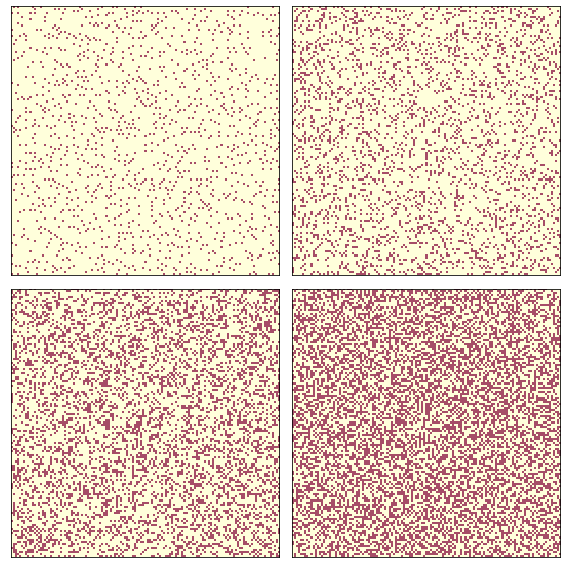

In [6]:
draw_four(pile)

level=0 | dimension=2.024867499865191
level=1 | dimension=1.9154612290559654
level=2 | dimension=1.9498980292992822
level=3 | dimension=2.0202410967104534


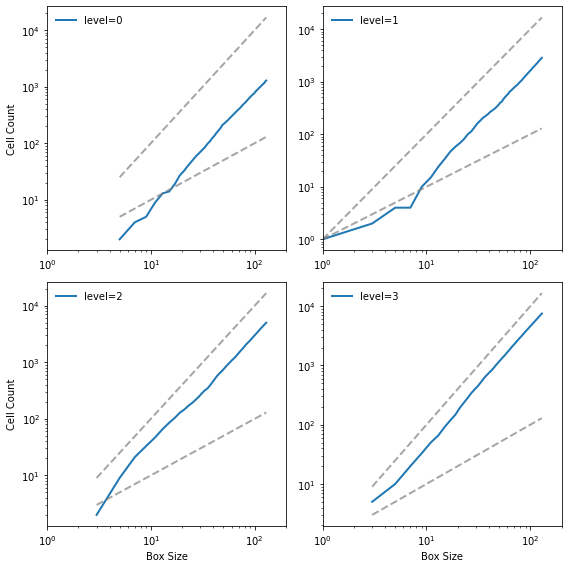

In [7]:
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    dim = box_count(pile, level=i, plot=True)
    print(f"level={i} | dimension={dim}")

plt.tight_layout()

We see that the dimensions for levels 1 and 2 do not seem to be integers and the cell count curve lie in between those for d=1 and d=2. This indicates that the piles in those levels may be fractals.